# Basic workflow for AL in Fink Stream with ML flow logging.

The goal of this notebook is to explore how to set up an Active Learning Loop for the VRA in the Fink ZTF stream with ML flow logging. It also **initialises our AL training experiment [Training Round 0]** by doing the first round of training. 

The data is polled every hour with a cron job and the `consumer.py` utility to the `finkvra` package, so I don't poll data here. 

For this first round of training I use only data from the first day of polling: **2025-06-02**


## 1. Basic imports and loading the data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import json

lasair_base_url = 'https://lasair-ztf.lsst.ac.uk/objects/'

In [2]:
glob('/home/stevance/Data/FinkZTFStream/20250602*.parquet')

['/home/stevance/Data/FinkZTFStream/20250602_205102_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_110001_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_103002_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_094059_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_175102_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_235101_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_124502_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_145102_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_091131_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_144502_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_215101_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_143002_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_131502_alerts.parquet',
 '/home/stevance/Data/FinkZTFStream/20250602_130002_alerts.parquet',
 '/home/stevance/Data/FinkZTFStrea

### Note on the parquet import:
Although I should be able to directly read `'/home/stevance/Data/FinkZTFStream/20250602*.parquet'` into pandas I was getting weird errors, but loading the files one by one works, so that's what I'm doing here. 

In [3]:

files = sorted(glob('/home/stevance/Data/FinkZTFStream/20250602*.parquet'))
dfs = [pd.read_parquet(f) for f in files]
data = pd.concat(dfs, ignore_index=True)

In [4]:
data

,candid,objectId,ra,dec,drb,mjd,mag,maglim,fid,isdiffpos,lc_features_g,lc_features_r,sherl_class,sep_arcsec
0,3069386415315015051,ZTF25aastlyj,288.662154,65.088530,0.961113,"[60823.38641199982, 60795.374525499996, 60795....","[19.527942657470703, nan, nan, nan, nan, nan, ...","[20.746294021606445, 20.559799194335938, 20.42...","[1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, ...","[t, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",ORPHAN,nan
1,3069387894915010012,ZTF25aastmkd,341.846733,72.183242,0.994998,"[60823.38789349981, 60795.426064800005, 60795....","[19.923898696899414, nan, nan, nan, nan, nan, ...","[20.43282127380371, 20.07029914855957, 20.3325...","[1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, ...","[f, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",ORPHAN,nan
2,3069382582215015014,ZTF25aastlfp,293.757494,24.732624,0.999734,"[60823.382581000216, 60794.36778939981, 60796....","[19.765827178955078, nan, nan, nan, nan, nan, ...","[20.979511260986328, 19.194499969482422, 20.71...","[1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, ...","[t, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",SN,1.2398935354229732
3,3069386410515015007,ZTF19aarxyde,286.972916,60.047391,0.999990,"[60823.38641199982, 60795.374525499996, 60795....","[20.550153732299805, 20.44420051574707, 20.580...","[20.800643920898438, 20.46809959411621, 20.658...","[1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, ...","[t, t, t, t, t, t, None, None, None, None, t, ...","{'amplitude': 0.0704956102857679, 'anderson_da...","{'amplitude': 0.03725671434644795, 'anderson_d...",SN,0.42265986534096434
4,3069388402015015013,ZTF25aastlnm,334.137737,46.956847,0.995750,"[60823.388402800076, 60795.427476900164, 60795...","[19.52053451538086, nan, nan, nan, nan, nan, n...","[20.7347354888916, 20.202800750732422, 20.4841...","[1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, ...","[t, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",SN,9.0563054064397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,3070413104315015004,ZTF25aatbatz,277.766458,41.382334,0.999993,"[60824.4131018999, 60795.41612270009, 60797.40...","[20.734960556030273, nan, nan, nan, 21.1009006...","[20.931304931640625, 20.56999969482422, 20.689...","[1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, ...","[t, None, None, None, t, None, None, None, Non...","{'amplitude': 0.04025968159231397, 'anderson_d...","{'amplitude': 0.06308281747452504, 'anderson_d...",SN,0.5857740426960156
79,3070412075015015028,ZTF25aatbbcw,273.312025,57.280857,0.995913,"[60824.41207179986, 60796.409872699995, 60796....","[19.72353172302246, nan, nan, nan, nan, nan, n...","[20.88239860534668, 20.64459991455078, 20.7581...","[1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, ...","[t, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",ORPHAN,nan
80,3070413574315010015,ZTF24aaiktge,279.710316,55.239723,0.999366,"[60824.41357639991, 60796.42160880007, 60796.4...","[20.573745727539062, 20.375699996948242, 20.66...","[20.945600509643555, 20.935100555419922, 21.02...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, ...","[f, f, f, f, f, f, None, f, None, f, f, f, f, ...","{'amplitude': 0.23250711515353828, 'anderson_d...","{'amplitude': 0.1793932950696071, 'anderson_da...",SN,0.17850624586349378
81,3070411125215010001,ZTF18aaztxiv,265.560914,51.144393,0.999999,"[60824.4111227002, 60796.4210994998, 60796.469...","[20.221134185791016, 20.223800659179688, 20.24...","[20.87544822692871, 20.871700286865234, 20.929...","[1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1

### Ploting utility 
Not super useful for now but good to have - so leaving here.

In [5]:
fid2col_dict={1:'navy', 2:'orange'}

def plot_lc(row):
    
    plt.scatter(row.mjd, row.mag, 
                c=[fid2col_dict[fid] for fid in row.fid])

    plt.scatter(row.mjd, row.maglim, 
                c=[fid2col_dict[fid] for fid in row.fid], alpha=0.3, marker ='v')
    
    neg_diffs = (row.isdiffpos == 'f')
    if sum(neg_diffs) !=0:
        plt.scatter(row.mjd, row.mag, 
            c=[fid2col_dict[fid] for fid in row.fid], marker='h', s=70, zorder=100)
        
    plt.gca().invert_yaxis()

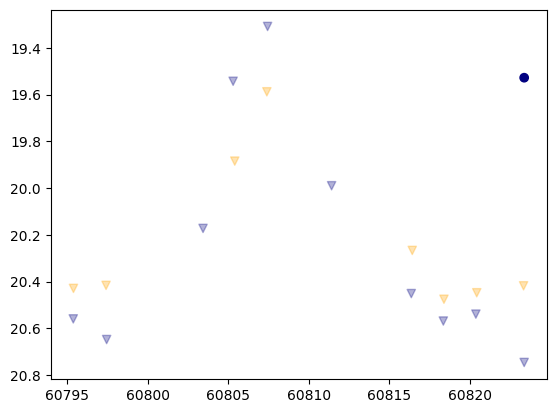

In [6]:
plot_lc(data.iloc[0])

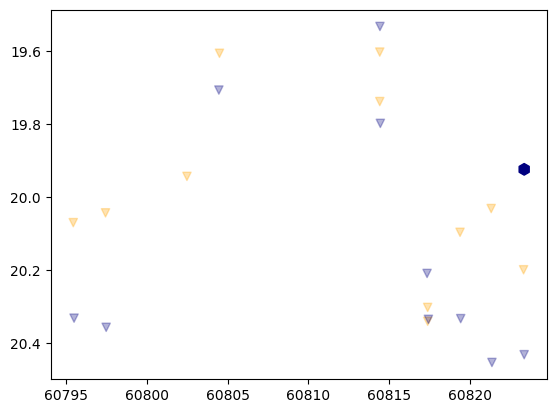

In [7]:
plot_lc(data.iloc[1])

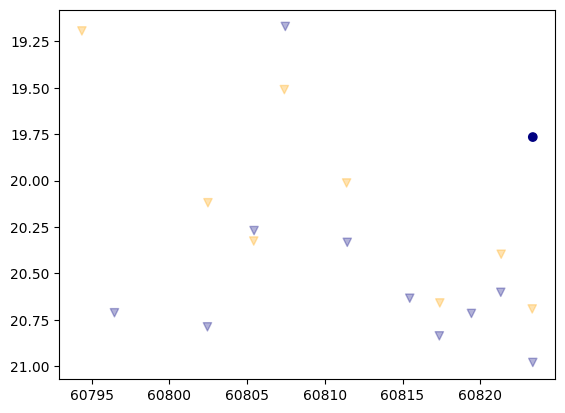

In [8]:
plot_lc(data.iloc[2])

## 2. Make features X

I've now abstracted away the features to the `finkvra` package.

In [9]:
from finkvra.utils.features import make_features
X, meta = make_features(data)

In [10]:
X

,ra,dec,drb,ndets,nnondets,dets_median,dets_std,sep_arcsec,amplitude,linear_fit_reduced_chi2,...,linear_fit_slope_sigma,median,median_absolute_deviation,amplituder_,linear_fit_reduced_chi2r_,linear_fit_sloper_,linear_fit_slope_sigmar_,medianr_,median_absolute_deviationr_,ebv
candid,,,,,,,,,,,,,,,,,,,,,
3069386415315015051,288.662154,65.088530,0.961113,1.0,17.0,19.527943,0.000000,nan,0.000000,NaN,...,NaN,19.527943,0.000000,0.000000,NaN,NaN,NaN,19.527943,0.000000,0.108660
3069387894915010012,341.846733,72.183242,0.994998,0.0,20.0,NaN,NaN,nan,0.000000,NaN,...,NaN,19.923899,0.000000,0.000000,NaN,NaN,NaN,19.923899,0.000000,0.438332
3069382582215015014,293.757494,24.732624,0.999734,1.0,17.0,19.765827,0.000000,1.2398935354229732,0.000000,NaN,...,NaN,19.765827,0.000000,0.000000,NaN,NaN,NaN,19.765827,0.000000,1.916294
3069386410515015007,286.972916,60.047391,0.999990,11.0,6.0,20.475401,0.075382,0.42265986534096434,0.070496,0.069703,...,0.004152,19.842197,0.018932,0.070496,0.069703,0.003666,0.004152,19.842197,0.018932,0.075731
3069388402015015013,334.137737,46.956847,0.995750,1.0,16.0,19.520535,0.000000,9.0563054064397,0.000000,NaN,...,NaN,19.520535,0.000000,0.000000,NaN,NaN,NaN,19.520535,0.000000,0.159215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3070413104315015004,277.766458,41.382334,0.999993,7.0,11.0,20.906900,0.119133,0.5857740426960156,0.040260,0.000122,...,0.024479,19.977603,0.021508,0.040260,0.000122,-0.009992,0.024479,19.977603,0.021508,0.065384
3070412075015015028,273.312025,57.280857,0.995913,1.0,33.0,19.723532,0.000000,nan,0.000000,NaN,...,NaN,19.723532,0.000000,0.000000,NaN,NaN,NaN,19.723532,0.000000,0.037474
3070413574315010015,279.710316,55.239723,0.999366,0.0,2.0,NaN,NaN,0.17850624586349378,0.232507,0.172378,...,0.011843,21.010233,0.080893,0.232507,0.172378,-0.001165,0.011843,21.010233,0.080893,0.040900


We only care about the alerts that have **positive differences**. 

In [11]:
valid_candid = list(X[X.ndets>0].index.values)
X = X.loc[valid_candid]
meta = meta.loc[valid_candid]

In [12]:
# If we want to see the links to the objects in Lasair
pd.set_option("display.max_colwidth", 500)
meta.apply(lambda row: f"{lasair_base_url}{row['objectId']}", axis=1)

candid
3069386415315015051    https://lasair-ztf.lsst.ac.uk/objects/ZTF25aastlyj
3069382582215015014    https://lasair-ztf.lsst.ac.uk/objects/ZTF25aastlfp
3069386410515015007    https://lasair-ztf.lsst.ac.uk/objects/ZTF19aarxyde
3069388402015015013    https://lasair-ztf.lsst.ac.uk/objects/ZTF25aastlnm
3069388403815015014    https://lasair-ztf.lsst.ac.uk/objects/ZTF21abiumls
3069382583515015017    https://lasair-ztf.lsst.ac.uk/objects/ZTF25aastmlg
3069386414215015010    https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasrort
3069387892715015046    https://lasair-ztf.lsst.ac.uk/objects/ZTF22abcimzy
3069383052515015018    https://lasair-ztf.lsst.ac.uk/objects/ZTF18aaxlpcz
3069386413215015028    https://lasair-ztf.lsst.ac.uk/objects/ZTF25aastmyg
3069383051615015019    https://lasair-ztf.lsst.ac.uk/objects/ZTF19acbpyal
3069383054815015012    https://lasair-ztf.lsst.ac.uk/objects/ZTF25aastnee
3069386413215015015    https://lasair-ztf.lsst.ac.uk/objects/ZTF25aastmyh
3070410643915015008    https://

In [13]:
X.to_csv('../../Data/FinkZTFStream/X.csv')
meta.to_csv('../../Data/FinkZTFStream/meta.csv')

There were labeled using the command line tool `finkvra.utils.labels.cli_label_alerts` and saved to `~/Data/FinkZTFStream/labeled.csv`. 

## 3. Load in the labels and turn them to classifications

To make our binary classifier we must turn our binary labels into binary classes. 
We're going to do this with dictionaries


In [14]:
label2galclass = {'real': np.nan,
                  'extragal': 0,
                  'gal': 1,
                  'agn': 0,
                  'bogus': np.nan,
                  'varstar': 1,
                  None: np.nan,
                  np.nan: np.nan,
                 }

label2realclass = {'real': 1,
                  'extragal': 1,
                  'gal': 1,
                  'agn': 1,
                  'bogus': 0,
                  'varstar': 1,
                  None: np.nan,
                  np.nan: np.nan,
                 }

label2transclass = {'real': np.nan,
                  'extragal': 1,
                  'gal': 1,
                  'agn': 0,
                  'bogus': np.nan,
                  'varstar': 0,
                  None: np.nan,
                  np.nan: np.nan,
                 }

In [15]:
labels = pd.read_csv('../../Data/FinkZTFStream/labeled.csv', index_col=0)

In [16]:
labels

,objectId,label,timestamp
candid,,,
3069386410515015007,ZTF19aarxyde,varstar,2025-06-02T08:37:22.993787
3069386415315015051,ZTF25aastlyj,real,2025-06-02T08:38:09.167712
3069382582215015014,ZTF25aastlfp,varstar,2025-06-02T08:38:35.964541
3069388402015015013,ZTF25aastlnm,varstar,2025-06-02T08:38:48.162550
3069382583515015017,ZTF25aastmlg,varstar,2025-06-02T09:44:44.227317
...,...,...,...
3072413572515015193,ZTF25aatifwl,real,2025-06-05T13:14:19.761350
3072419752515015002,ZTF25aasdbss,extragal,2025-06-05T13:14:19.761350
3072412154615015021,ZTF18acvwtyw,gal,2025-06-05T13:14:19.761350


In [17]:
labels['gal_type'] = labels.apply(lambda row: label2galclass[row.label], axis=1)
labels['real_type'] = labels.apply(lambda row: label2galclass[row.label], axis=1)
labels['trans_type'] = labels.apply(lambda row: label2galclass[row.label], axis=1)

In [18]:
labels

,objectId,label,timestamp,gal_type,real_type,trans_type
candid,,,,,,
3069386410515015007,ZTF19aarxyde,varstar,2025-06-02T08:37:22.993787,1.0,1.0,1.0
3069386415315015051,ZTF25aastlyj,real,2025-06-02T08:38:09.167712,NaN,NaN,NaN
3069382582215015014,ZTF25aastlfp,varstar,2025-06-02T08:38:35.964541,1.0,1.0,1.0
3069388402015015013,ZTF25aastlnm,varstar,2025-06-02T08:38:48.162550,1.0,1.0,1.0
3069382583515015017,ZTF25aastmlg,varstar,2025-06-02T09:44:44.227317,1.0,1.0,1.0
...,...,...,...,...,...,...
3072413572515015193,ZTF25aatifwl,real,2025-06-05T13:14:19.761350,NaN,NaN,NaN
3072419752515015002,ZTF25aasdbss,extragal,2025-06-05T13:14:19.761350,0.0,0.0,0.0
3072412154615015021,ZTF18acvwtyw,gal,2025-06-05T13:14:19.761350,1.0,1.0,1.0


In [19]:
y_real = labels['real_type']
y_gal = labels['gal_type']
y_trans = labels['trans_type']

In [20]:
y_real

candid
3069386410515015007    1.0
3069386415315015051    NaN
3069382582215015014    1.0
3069388402015015013    1.0
3069382583515015017    1.0
                      ... 
3072413572515015193    NaN
3072419752515015002    0.0
3072412154615015021    1.0
3070419904815015027    NaN
3072421642915015021    0.0
Name: real_type, Length: 105, dtype: float64

## 4. Let's make some models! 

As usual I'm going to use my trusted **Histogram Based Gradient Boosted Classifiers**. 

For now I'm using the **accurary** as a metric. Not my fave and will have to think about this, but these are initial tests and it's easy. 

In [36]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from mlflow.models.signature import infer_signature

In [22]:
id2use_gal_class = list(set(y_gal[y_gal.isna()==False].index).intersection(set(X.index)))
id2use_real_class = list(set(y_real[y_real.isna()==False].index).intersection(set(X.index)))
id2use_trans_class = list(set(y_trans[y_trans.isna()==False].index).intersection(set(X.index)))

In [23]:
y_gal.loc[id2use_gal_class].shape

(40,)

In [24]:
y_real.loc[id2use_real_class].shape

(40,)

In [25]:
y_trans.loc[id2use_trans_class].shape

(40,)

### Setting up ML Flow - one model at a time
For now I'm going to do separate experiments for the galactic, real (and transient?) models. 

I am starting with Galactic because there aren't many boguses in the ZTF stream. 

Before running this it's important to have opened the server on my local machine (**from the home directory**) with:

```bash
mlflow server --host 127.0.0.1 --port 6969
```

In [26]:
import mlflow

mlflow.set_tracking_uri(uri="http://127.0.0.1:6969") 
EXPERIMENT_NAME = "SEP25gal_model_AL"  # Name of the experiment for MLflow tracking
mlflow.set_experiment(EXPERIMENT_NAME) # This is the name of the experiment we need for everything to go in the same place from round to round

2025/09/30 15:15:45 INFO mlflow.tracking.fluent: Experiment with name 'SEP25gal_model_AL' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/575240719855823327', creation_time=1759241745077, experiment_id='575240719855823327', last_update_time=1759241745077, lifecycle_stage='active', name='SEP25gal_model_AL', tags={}>

### Make training data

In [27]:
X, y = X.loc[id2use_gal_class], y_gal.loc[id2use_gal_class]

### Infer the ML Flow signature form our input and output DF

In [28]:
infer_signature?

In [29]:
signature = infer_signature(X, y)

In [30]:
signature

inputs: 
  ['ra': double (required), 'dec': double (required), 'drb': double (required), 'ndets': double (required), 'nnondets': double (required), 'dets_median': double (required), 'dets_std': double (required), 'sep_arcsec': string (required), 'amplitude': double (required), 'linear_fit_reduced_chi2': double (optional), 'linear_fit_slope': double (optional), 'linear_fit_slope_sigma': double (optional), 'median': double (required), 'median_absolute_deviation': double (required), 'amplituder_': double (required), 'linear_fit_reduced_chi2r_': double (optional), 'linear_fit_sloper_': double (optional), 'linear_fit_slope_sigmar_': double (optional), 'medianr_': double (required), 'median_absolute_deviationr_': double (required), 'ebv': float (required)]
outputs: 
  ['gal_type': double (required)]
params: 
  None

### Sample N alerts

I am gonna chose ``N=30`` because:
* 1) It starts us off with not too few samples 
* 2) Eyeballing 30 alerts doesn't take that long so it's not a bad place to start

In [31]:
N = 30 
# sample N rows randomly form y 
sampled_ids = np.random.choice(y.index, N, replace=False)
y_train = y.loc[sampled_ids]
X_train = X.loc[sampled_ids]

In [32]:
training_ids_df = y_train.copy().to_frame()
training_ids_df['round'] = 0
training_ids_df = training_ids_df[['round']]
training_ids_df.to_csv(f'./{EXPERIMENT_NAME}_training_ids.csv')

In [33]:
from datetime import datetime

In [37]:
# Start MLflow run
l2_reg = 10
lr = 0.1
randstate = 42
max_n_trees = 100
CURRENT_ROUND = 0
SAMPLING_STRATEGY = "uncertainty" 
# when we start it's obviously random but this is the beginning of our undertainty sampling experiment 
ARTIFACT_PATH = "gal_model"
MODEL_TAG = f"{ARTIFACT_PATH}_round_{CURRENT_ROUND}"

with mlflow.start_run(run_name=f"round_{CURRENT_ROUND}_{SAMPLING_STRATEGY}"):

    # Log metadata
    meta_info = {
        "round": int(CURRENT_ROUND),
        "timestamp": datetime.utcnow().isoformat(),
        "n_train": int(X_train.shape[0]),
        "sampling_strategy": str(SAMPLING_STRATEGY),
        "model_tag": str(MODEL_TAG)
    }
    
    with open("meta.json", "w") as f:
        json.dump(meta_info, f, indent=2)
    mlflow.log_artifact("meta.json")

    # Optional: fit on all data and log final model
    clf = HistGradientBoostingClassifier(max_iter=max_n_trees , 
                                            l2_regularization=l2_reg,
                                            random_state=randstate,
                                            learning_rate=lr)
    clf.fit(X_train, y_train)
    mlflow.sklearn.log_model(clf, 
                             artifact_path="gal_model", 
                             input_example=X[:2],  # small batch
                             signature=signature)
    
    # Evaluate on training set
    acc = accuracy_score(y_train, clf.predict(X_train.values))
    mlflow.log_metric("accuracy", acc)
    
    prec = precision_score(y_train, clf.predict(X_train.values))
    mlflow.log_metric("precision", prec)
    
    recall = recall_score(y_train, clf.predict(X_train.values))
    mlflow.log_metric("recall", recall)
    
    f1 = f1_score(y_train, clf.predict(X_train.values))
    mlflow.log_metric("f1-score", f1)
    
    # Log parameters
    mlflow.log_param("max_iter", max_n_trees)
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("l2_regularization", l2_reg)


    # Log model
    signature = infer_signature(X_train, clf.predict(X_train))
    mlflow.sklearn.log_model(
        clf,
        artifact_path=ARTIFACT_PATH,
        signature=signature,
        input_example=X_train.iloc[:2]
    )

    # Save training state
    mlflow.log_artifact(f"{EXPERIMENT_NAME}_training_ids.csv")

/home/stevance/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/stevance/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/stevance/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/stevance/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(


🏃 View run round_0_uncertainty at: http://127.0.0.1:6969/#/experiments/575240719855823327/runs/16d68b3e880743b582a32d1a28ef4be5
🧪 View experiment at: http://127.0.0.1:6969/#/experiments/575240719855823327
